In [36]:
import os
import gpxpy
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString


In [37]:
# Parse GPX file, extract waypoint data
def parse_gpx(file_path):
    with open(file_path, 'r') as file:
        gpx = gpxpy.parse(file)
        points_data = []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points_data.append({'Latitude': point.latitude, 'Longitude': point.longitude})
        return pd.DataFrame(points_data)

# Plot waypoints, trajectories, routes
def plot_data(gdf):
    # Plot waypoints
    gdf.plot(marker='o', color='red', markersize=5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Waypoints Visualization')
    plt.show()

    # Plot trajectory
    trajectory = LineString(gdf['geometry'])
    trajectory_gdf = gpd.GeoDataFrame(geometry=[trajectory])
    trajectory_gdf.plot()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Trajectory')
    plt.show()

    # Plot each user routes.
    for user_id, group_data in gdf.groupby(level=0):
        line = LineString(group_data['geometry'])
        fig, ax = plt.subplots()
        ax.plot(line.xy[0], line.xy[1], label=f'User {user_id}')
        ax.legend()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Route for User {user_id}')
        plt.show()


def map_data(gdf):
    # Folium map centered at mean coordinates all waypoints
    map_center = [gdf['Latitude'].mean(), gdf['Longitude'].mean()]
    mymap = folium.Map(location=map_center, zoom_start=13)

    # Add waypoints to the map
    marker_cluster = FastMarkerCluster(gdf[['Latitude', 'Longitude']].values.tolist())
    mymap.add_child(marker_cluster)

    # Plot trajectory
    trajectory = gdf['geometry'].unary_union
    folium.GeoJson(data=trajectory.__geo_interface__).add_to(mymap)

    # Plot routes each user
    for user_id, group_data in gdf.groupby(level=0):
        line = group_data['geometry'].unary_union
        folium.GeoJson(data=line.__geo_interface__, name=f'User {user_id}').add_to(mymap)

    return mymap


In [38]:
# GPX dir
gpx_dir = 'user_profiles'

# Read GPX files, parse waypoints.
dfs = []
for filename in os.listdir(gpx_dir):
    if filename.endswith('.gpx'):
        gpx_file_path = os.path.join(gpx_dir, filename)
        df = parse_gpx(gpx_file_path)
        dfs.append(df)

# Concatenate DataFrames into DataFrame
gdf = pd.concat(dfs, keys=range(1, len(dfs) + 1))

In [39]:
# GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.Longitude, gdf.Latitude))

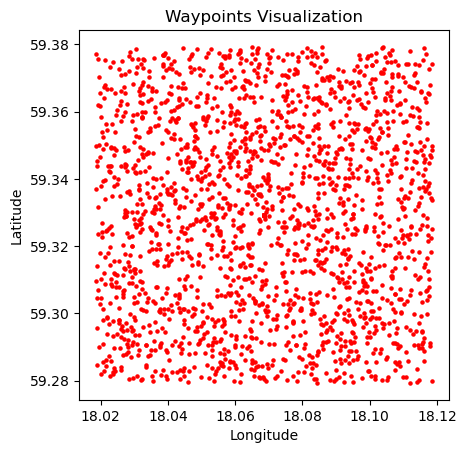

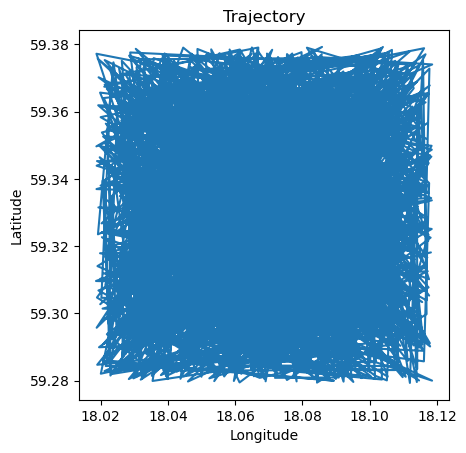

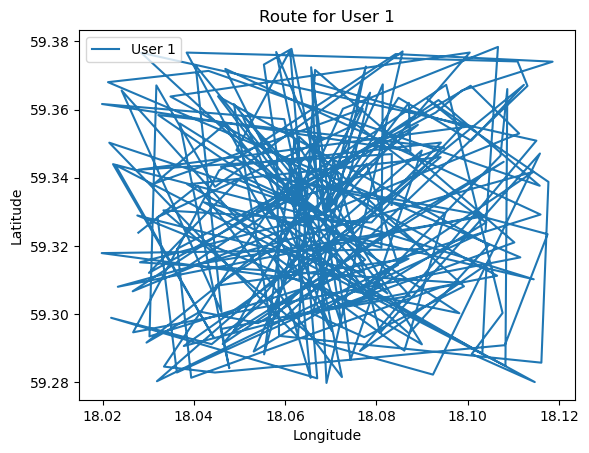

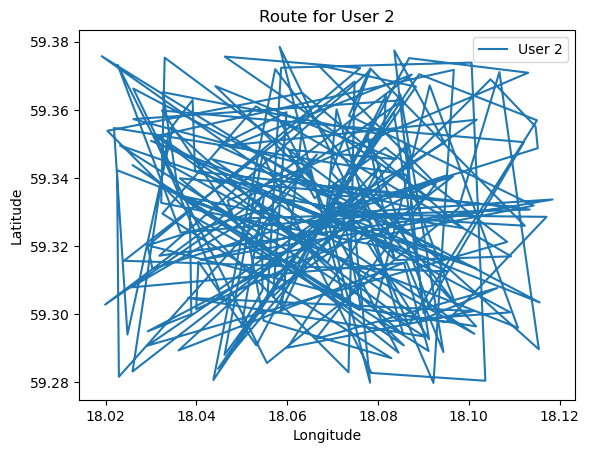

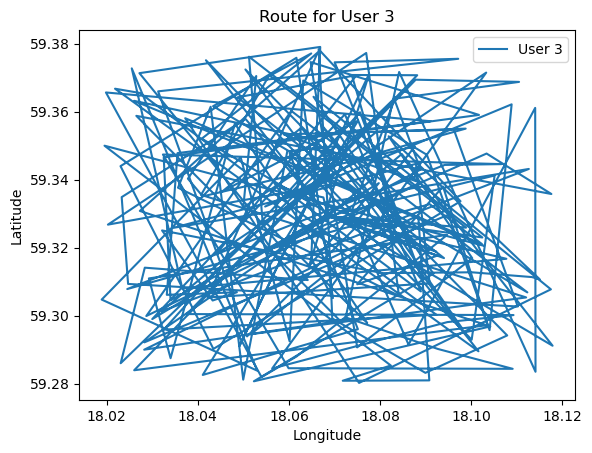

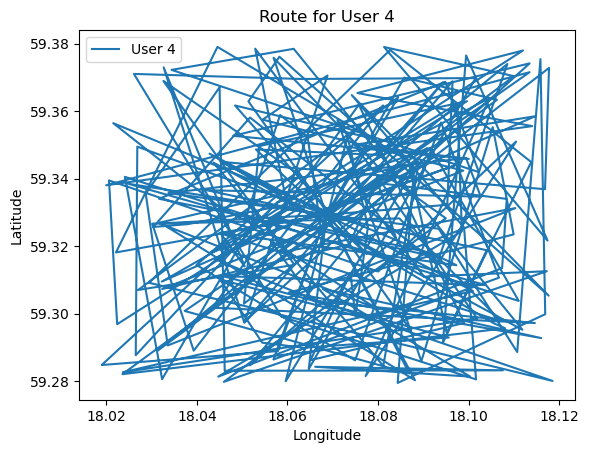

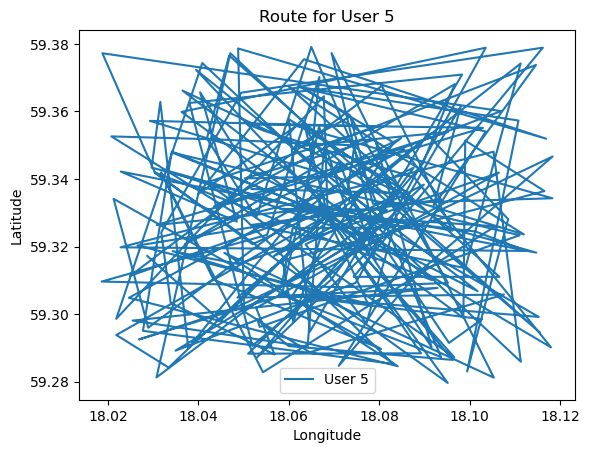

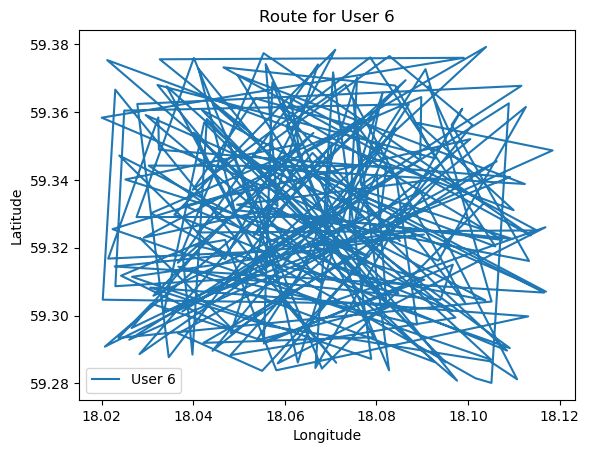

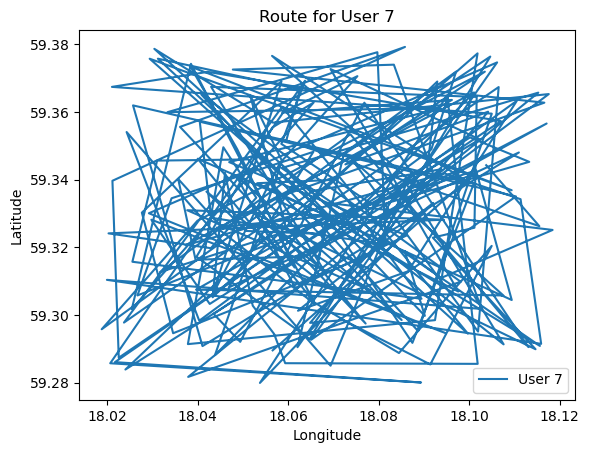

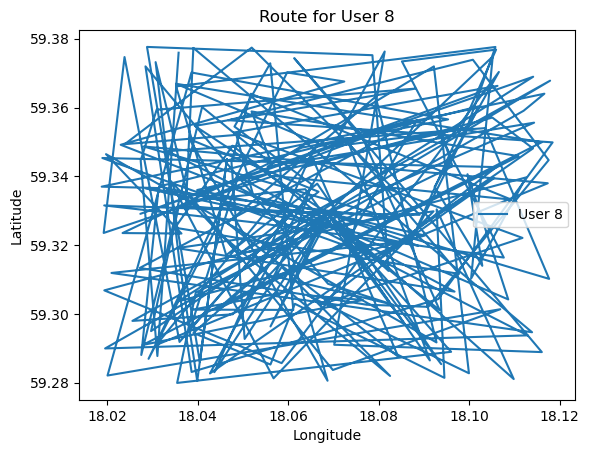

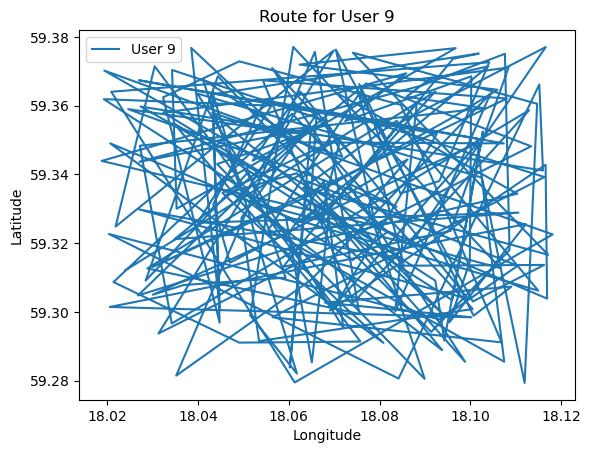

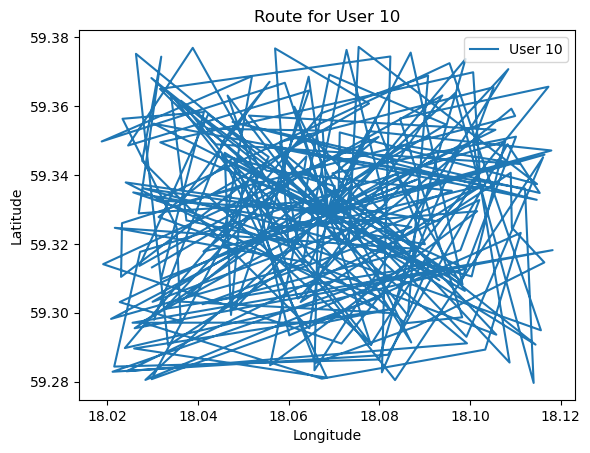

In [40]:
# Plot/map waypoints, trajectory, routes
plot_data(gdf)
map_data(gdf)


In [41]:
# Map specific user data
user_1 = gdf.loc[1]
map_data(user_1)